In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dolfin import *

import sys
#print(sys.path)
#sys.path.insert(0, '~/projects/reaktoro_transport-git')
sys.path.insert(0, '..')
import reaktoro_transport.solver as solver


['/home/powei/projects/reaktoro_transport-git/tutorial', '/home/powei/anaconda3/envs/fenicsproject/lib/python37.zip', '/home/powei/anaconda3/envs/fenicsproject/lib/python3.7', '/home/powei/anaconda3/envs/fenicsproject/lib/python3.7/lib-dynload', '', '/home/powei/anaconda3/envs/fenicsproject/lib/python3.7/site-packages', '/home/powei/anaconda3/envs/fenicsproject/lib/python3.7/site-packages/IPython/extensions', '/home/powei/.ipython']


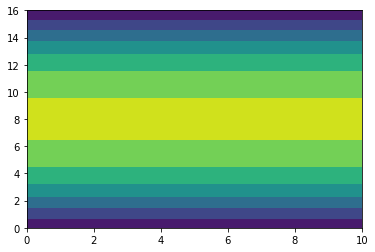

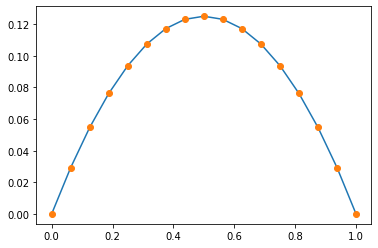

<class 'dolfin.function.function.Function'>


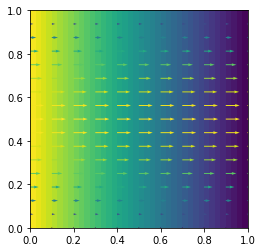

In [57]:
nx_nd = 10
ny_nd = 16
mesh_2d = UnitSquareMesh(nx_nd, ny_nd)

#print(type(mesh_2d))

class top_bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[1], 0, DOLFIN_EPS) or near(x[1], 1.0, DOLFIN_EPS))

u, p = solver.stokes_lubrication(mesh_2d, 0.1, top_bottom)

u_y = u.compute_vertex_values(mesh_2d).reshape(2, ny_nd+1, nx_nd+1)[0,:,5]

u_mesh = u.compute_vertex_values(mesh_2d).reshape(2, ny_nd+1, nx_nd+1)[0,:,:]

plt.figure()
plt.contourf(u_mesh)
plt.show()


y_space = np.linspace(0,1,ny_nd+1)
asym_sol = -0.5*(y_space-1)*y_space

plt.figure()
plt.plot(y_space, asym_sol)
plt.plot(y_space, u_y, 'o')
plt.show()

print(type(u))
plot(p)
plot(u)

In [11]:
def adv_diff_reac_sol_fracture(Pe, Da, eps, C_b, x_space):
    k = 0
    alpha2 = 2*Da/eps**2
    G_plus  = 1.0/24*(Pe + (576*alpha2 + Pe**2 - 576*k*Pe)**0.5)
    G_minus = 1.0/24*(Pe - (576*alpha2 + Pe**2 - 576*k*Pe)**0.5)

    k2 = (alpha2/(alpha2 - k*Pe) - C_b)/(-1 + G_plus/G_minus*np.exp(G_plus-G_minus))
    k1 = C_b - alpha2/(alpha2-k*Pe) - k2

    C = alpha2/(alpha2-k*Pe) + k1*np.exp(x_space*G_minus) + k2*np.exp(x_space*G_plus)

    return C

Pe =  0.0 Da =  0.31499999999999995 alpha^2 =  7.937253933193771 0.09999999999999999


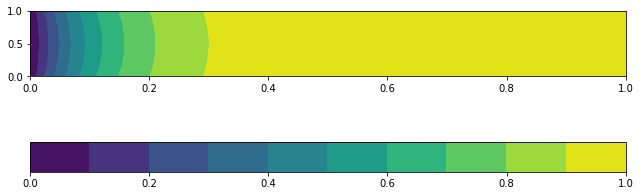

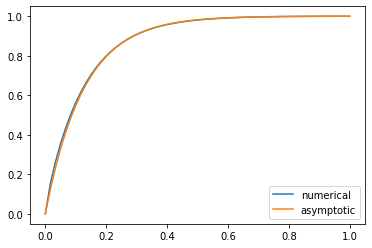

In [36]:
nx_nd = 60
ny_nd = 30
mesh_2d = UnitSquareMesh(nx_nd, ny_nd)

Lx = 1e-5 #cm
Ly = 1e-6

Dc = 1e-5 #0.85e-4 #Diffusivity
uc = 0 #1e-2 #Characteristic velocity
k = 3.15 #1.9e-5 #cm s-1

epsilon = Ly/Lx
Pe = Lx*uc/Dc
Da = Ly*k/Dc
A = (2*Da)**0.5/epsilon

xspace = np.linspace(0,1,nx_nd+1)
yspace = np.linspace(0,1,ny_nd+1)

xx, yy = np.meshgrid(xspace, yspace)

print('Pe = ', Pe, 'Da = ', Da, 'alpha^2 = ', A, epsilon)
C = solver.concentration_transport2D(mesh_2d, epsilon, Pe, Da, 1, 0, 'Cartesian')

fig = plt.figure(figsize=(9,4))
C_vertex = C.compute_vertex_values(mesh_2d).reshape(ny_nd+1, nx_nd+1)
im1 = plt.contourf(xx, yy, C_vertex, levels=np.linspace(0,1,11))


fig.colorbar(im1, orientation="horizontal", fraction=0.5, pad=0.25)
#plt.savefig('calcite_dissolution.png', dpi=400)
plt.tight_layout()

plt.show()

C_y0 = C_vertex[0,:]
#print(len(C_y0))
C_y1 = C_vertex[-1,:]

plt.figure()
plt.plot(xspace, C_y0)
plt.plot(xspace, adv_diff_reac_sol_fracture(Pe, Da, epsilon, 0, xspace))
plt.legend(['numerical', 'asymptotic'])
plt.show()